In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [ ]:
!gdown --id '1C7N6k8Cf8_9fzuwdjZ2k0B9AckSUc4jU' --output level-6.csv

Downloading...
From: https://drive.google.com/uc?id=1C7N6k8Cf8_9fzuwdjZ2k0B9AckSUc4jU
To: /content/level-6.csv
100% 781k/781k [00:00<00:00, 4.79MB/s]


In [ ]:
train = pd.read_csv("level-6.csv")
train.head()

,index,Archaea;Crenarchaeota;Nitrososphaeria;Nitrososphaerales;Nitrososphaeraceae;Candidatus_Nitrocosmicus,Archaea;Crenarchaeota;Nitrososphaeria;Nitrososphaerales;Nitrososphaeraceae;Candidatus_Nitrososphaera,Archaea;Crenarchaeota;Nitrososphaeria;Nitrososphaerales;Nitrososphaeraceae;__,Archaea;Thermoplasmatota;Thermoplasmata;Thermoplasmatales;Thermoplasmataceae;uncultured,Archaea;__;__;__;__;__,Bacteria;Abditibacteriota;Abditibacteria;Abditibacteriales;Abditibacteriaceae;Abditibacterium,Bacteria;Acidobacteria;Acidobacteriia;Acidobacteriales;Acidobacteriaceae;PAC001990,Bacteria;Acidobacteria;Blastocatellia;Blastocatellales;PAC000004;EU192989,Bacteria;Acidobacteria;CP011806;CP011806;CP011806;CP011806,Bacteria;Acidobacteria;CP011806;CP011806;PAC002217;PAC002217,Bacteria;Acidobacteria;PAC001813;PAC001813;PAC001813;PAC001813,Bacteria;Acidobacteria;PAC001852;PAC001852;PAC001852;PAC001852,Bacteria;Acidobacteria;PAC001852;PAC001852;PAC001852;PAC002038,Bacteria;Acidobacteria;PAC001852;PAC001852;PAC001852;__,Bacteria;Acidobacteria;Solibacteres;Solibacterales;Bryobacteraceae;PAC002019,Bacteria;Acidobacteria;Vicinamibacter;Vicinamibacter;PAC002281;PAC002281,Bacteria;Acidobacteria;Vicinamibacter;Vicinamibacter;Vicinamibacter;PAC001869,Bacteria;Acidobacteria;Vicinamibacter;Vicinamibacter;Vicinamibacter;PAC001874,Bacteria;Acidobacteriota;Acidobacteriae;Acidobacteriales;Acidobacteriaceae_(Subgroup_1);uncultured,Bacteria;Acidobacteriota;Acidobacteriae;Bryobacterales;Bryobacteraceae;Bryobacter,Bacteria;Acidobacteriota;Blastocatellia;11-24;__;__,Bacteria;Acidobacteriota;Blastocatellia;11-24;uncultured_Pelobacter_sp.;,Bacteria;Acidobacteriota;Blastocatellia;Blastocatellales;Blastocatellaceae;Aridibacter,Bacteria;Acidobacteriota;Blastocatellia;Blastocatellales;Blastocatellaceae;Blastocatella,Bacteria;Acidobacteriota;Blastocatellia;Blastocatellales;Blastocatellaceae;__,Bacteria;Acidobacteriota;Blastocatellia;Blastocatellales;Blastocatellaceae;uncultured,Bacteria;Acidobacteriota;Blastocatellia;Elev-16S-573;uncultured_microorganism;,Bacteria;Acidobacteriota;Blastocatellia;Pyrinomonadales;Pyrinomonadaceae;RB41,Bacteria;Acidobacteriota;Holophagae;Subgroup_7;Acidobacteria_bacterium;,Bacteria;Acidobacteriota;Holophagae;Subgroup_7;__;__,Bacteria;Acidobacteriota;Subgroup_11;__;__;__,Bacteria;Acidobacteriota;Subgroup_11;uncultured_sponge_symbiont_PAUC37f;;__,Bacteria;Acidobacteriota;Subgroup_18;alkali_sediment_metagenome;;__,Bacteria;Acidobacteriota;Subgroup_22;__;__;__,Bacteria;Acidobacteriota;Subgroup_25;uncultured_Firmicutes_bacterium;;__,Bacteria;Acidobacteriota;Subgroup_5;uncultured_Acidobacteriales_bacterium;;__,Bacteria;Acidobacteriota;Thermoanaerobaculia;Thermoanaerobaculales;Thermoanaerobaculaceae;Subgroup_10,Bacteria;Acidobacteriota;Vicinamibacteria;Subgroup_17;__;__,Bacteria;Acidobacteriota;Vicinamibacteria;Subgroup_17;agricultural_soil_bacterium_SC-I-8;,...,Bacteria;Proteobacteria;Gammaproteobacteria;Salinisphaerales;Solimonadaceae;uncultured,Bacteria;Proteobacteria;Gammaproteobacteria;Steroidobacterales;Steroidobacteraceae;Steroidobacter,Bacteria;Proteobacteria;Gammaproteobacteria;Steroidobacterales;Steroidobacteraceae;__,Bacteria;Proteobacteria;Gammaproteobacteria;Steroidobacterales;Steroidobacteraceae;uncultured,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Rhodanobacteraceae;uncultured,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Arenimonas,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Luteimonas,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Lysobacter,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Pseudoxanthomonas,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Stenotrophomonas,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Thermomonas,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Vulcaniibacterium,Bacteria;Proteobac

In [ ]:
shortrun = train[train['Merged'] < 920].index
train = train.drop(shortrun,axis=0)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 413
Columns: 710 entries, index to Cancer
dtypes: float64(707), int64(1), object(2)
memory usage: 2.2+ MB


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 413
Columns: 710 entries, index to Cancer
dtypes: float64(707), int64(1), object(2)
memory usage: 2.2+ MB


In [ ]:
CAT_COL = ["index", "Cancer"]

NUM_COL=[]
for i in range(len(train.columns)):
  NUM_COL.append(train.columns[i])
NUM_COL.remove('index')
NUM_COL.remove('Cancer')

cat_col = []
num_col = []
for col in train:
  if col in CAT_COL:
    cat_col.append(col)
  elif col in NUM_COL:
    num_col.append(col)
for col in cat_col:
  train[col] = train[col].astype(str)

df_cat = train.loc[:,cat_col] # take all the categorical columns
df_cat = pd.get_dummies(df_cat) # one hot encoding

df_num = train.loc[:,num_col] # take all the numerical columns
df_final = pd.concat([df_cat, df_num], axis=1) # concat categorical/numerical data

In [ ]:
df_final.head()

,index_SRR3991006,index_SRR3991007,index_SRR3991008,index_SRR3991009,index_SRR3991010,index_SRR3991011,index_SRR3991012,index_SRR3991013,index_SRR3991014,index_SRR3991015,index_SRR3991016,index_SRR3991017,index_SRR3991018,index_SRR3991019,index_SRR3991020,index_SRR3991021,index_SRR3991022,index_SRR3991023,index_SRR3991024,index_SRR3991025,index_SRR3991026,index_SRR3991027,index_SRR3991028,index_SRR3991029,index_SRR3991030,index_SRR3991032,index_SRR3991033,index_SRR3991034,index_SRR3991035,index_SRR3991036,index_SRR3991037,index_SRR3991038,index_SRR3991039,index_SRR3991040,index_SRR3991041,index_SRR3991042,index_SRR3991043,index_SRR3991044,index_SRR3991045,index_SRR3991046,...,Bacteria;Proteobacteria;Gammaproteobacteria;Salinisphaerales;Solimonadaceae;Nevskia,Bacteria;Proteobacteria;Gammaproteobacteria;Salinisphaerales;Solimonadaceae;uncultured,Bacteria;Proteobacteria;Gammaproteobacteria;Steroidobacterales;Steroidobacteraceae;Steroidobacter,Bacteria;Proteobacteria;Gammaproteobacteria;Steroidobacterales;Steroidobacteraceae;__,Bacteria;Proteobacteria;Gammaproteobacteria;Steroidobacterales;Steroidobacteraceae;uncultured,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Rhodanobacteraceae;uncultured,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Arenimonas,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Luteimonas,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Lysobacter,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Pseudoxanthomonas,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Stenotrophomonas,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Thermomonas,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Vulcaniibacterium,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Xanthomonas,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;__,Bacteria;Proteobacteria;Gammaproteobacteria;__;__;__,Bacteria;Proteobacteria;__;__;__;__,Bacteria;SAR324_clade(Marine_group_B);uncultured_Phaselicystis_sp.;;__;__,Bacteria;Saccharibacteria_TM7;Saccharimonas;Saccharimonas;PAC000016;AY792306,Bacteria;Spirochaetota;Spirochaetia;Spirochaetales;Spirochaetaceae;Sediminispirochaeta,Bacteria;Spirochaetota;Spirochaetia;Spirochaetales;Spirochaetaceae;Treponema,Bacteria;Sva0485;uncultured_Geobacter_sp.;;__;__,Bacteria;Synergistota;Synergistia;Synergistales;Synergistaceae;Fretibacterium,Bacteria;Synergistota;Synergistia;Synergistales;Synergistaceae;Pyramidobacter,Bacteria;Tenericutes;Mollicutes;Bacilloplasma;Lumbricoplasmataceae;GQ866067,Bacteria;Verrucomicrobia;Kiritimatiellae;EF436358;EF436358;EF436358,Bacteria;Verrucomicrobiota;Lentisphaeria;Victivallales;Victivallaceae;Victivallis,Bacteria;Verrucomicrobiota;Omnitrophia;Omnitrophales;Omnitrophaceae;Candidatus_Omnitrophus,Bacteria;Verrucomicrobiota;Verrucomicrobiae;Chthoniobacterales;Chthoniobacteraceae;Candidatus_Udaeobacter,Bacteria;Verrucomicrobiota;Verrucomicrobiae;Chthoniobacterales;Chthoniobacteraceae;Chthoniobacter,Bacteria;Verrucomicrobiota;Verrucomicrobiae;Chthoniobacterales;Chthoniobacteraceae;LD29,Bacteria;Verrucomicrobiota;Verrucomicrobiae;Opitutales;Opitutaceae;IMCC26134,Bacteria;Verrucomicrobiota;Verrucomicrobiae;Pedosphaerales;Pedosphaeraceae;ADurb.Bin063-1,Bacteria;Verrucomicrobiota;Verrucomicrobiae;Verrucomicrobiales;Akkermansiaceae;Akkermansia,Bacteria;Verrucomicrobiota;Verrucomicrobiae;Verrucomicrobiales;Verrucomicrobiaceae;Prosthecobacter,Bacteria;Verrucomicrobiota;Verrucomicrobiae;Verrucomicrobiales;Verrucomicrobiaceae;Verrucomicrobium,Bacteria;Zixibacteria;uncultured_gamma_proteobacterium;;__;__,Bacteria;__;__;__;__;__,Unassigned;__;__;__;__;__,Merged
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0

In [ ]:
not_select = ["index", "Cancer", "Merged"]
train_select = train.drop(not_select,axis=1)
train_select.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 413
Columns: 707 entries, Archaea;Crenarchaeota;Nitrososphaeria;Nitrososphaerales;Nitrososphaeraceae;Candidatus_Nitrocosmicus to Unassigned;__;__;__;__;__
dtypes: float64(707)
memory usage: 2.2 MB


In [ ]:
cat_col = []
num_col = []
for col in train_select:
  if col in CAT_COL:
    cat_col.append(col)
  elif col in NUM_COL:
    num_col.append(col)

for col in cat_col:
  if train_select[col].dtype != "O":
    # print(col)
    train_select[col] = train_select[col].astype(str)

df_cat_select = train_select.loc[:,cat_col] # take all the categorical columns
#df_cat_select = pd.get_dummies(df_cat_select) # one hot encoding

df_num_select = train_select.loc[:,num_col] # take all the numerical columns
df_final_select = pd.concat([df_cat_select, df_num_select], axis=1) # concat categorical/numerical data

In [ ]:
df_final_select.head()

,Archaea;Crenarchaeota;Nitrososphaeria;Nitrososphaerales;Nitrososphaeraceae;Candidatus_Nitrocosmicus,Archaea;Crenarchaeota;Nitrososphaeria;Nitrososphaerales;Nitrososphaeraceae;Candidatus_Nitrososphaera,Archaea;Crenarchaeota;Nitrososphaeria;Nitrososphaerales;Nitrososphaeraceae;__,Archaea;Thermoplasmatota;Thermoplasmata;Thermoplasmatales;Thermoplasmataceae;uncultured,Archaea;__;__;__;__;__,Bacteria;Abditibacteriota;Abditibacteria;Abditibacteriales;Abditibacteriaceae;Abditibacterium,Bacteria;Acidobacteria;Acidobacteriia;Acidobacteriales;Acidobacteriaceae;PAC001990,Bacteria;Acidobacteria;Blastocatellia;Blastocatellales;PAC000004;EU192989,Bacteria;Acidobacteria;CP011806;CP011806;CP011806;CP011806,Bacteria;Acidobacteria;CP011806;CP011806;PAC002217;PAC002217,Bacteria;Acidobacteria;PAC001813;PAC001813;PAC001813;PAC001813,Bacteria;Acidobacteria;PAC001852;PAC001852;PAC001852;PAC001852,Bacteria;Acidobacteria;PAC001852;PAC001852;PAC001852;PAC002038,Bacteria;Acidobacteria;PAC001852;PAC001852;PAC001852;__,Bacteria;Acidobacteria;Solibacteres;Solibacterales;Bryobacteraceae;PAC002019,Bacteria;Acidobacteria;Vicinamibacter;Vicinamibacter;PAC002281;PAC002281,Bacteria;Acidobacteria;Vicinamibacter;Vicinamibacter;Vicinamibacter;PAC001869,Bacteria;Acidobacteria;Vicinamibacter;Vicinamibacter;Vicinamibacter;PAC001874,Bacteria;Acidobacteriota;Acidobacteriae;Acidobacteriales;Acidobacteriaceae_(Subgroup_1);uncultured,Bacteria;Acidobacteriota;Acidobacteriae;Bryobacterales;Bryobacteraceae;Bryobacter,Bacteria;Acidobacteriota;Blastocatellia;11-24;__;__,Bacteria;Acidobacteriota;Blastocatellia;11-24;uncultured_Pelobacter_sp.;,Bacteria;Acidobacteriota;Blastocatellia;Blastocatellales;Blastocatellaceae;Aridibacter,Bacteria;Acidobacteriota;Blastocatellia;Blastocatellales;Blastocatellaceae;Blastocatella,Bacteria;Acidobacteriota;Blastocatellia;Blastocatellales;Blastocatellaceae;__,Bacteria;Acidobacteriota;Blastocatellia;Blastocatellales;Blastocatellaceae;uncultured,Bacteria;Acidobacteriota;Blastocatellia;Elev-16S-573;uncultured_microorganism;,Bacteria;Acidobacteriota;Blastocatellia;Pyrinomonadales;Pyrinomonadaceae;RB41,Bacteria;Acidobacteriota;Holophagae;Subgroup_7;Acidobacteria_bacterium;,Bacteria;Acidobacteriota;Holophagae;Subgroup_7;__;__,Bacteria;Acidobacteriota;Subgroup_11;__;__;__,Bacteria;Acidobacteriota;Subgroup_11;uncultured_sponge_symbiont_PAUC37f;;__,Bacteria;Acidobacteriota;Subgroup_18;alkali_sediment_metagenome;;__,Bacteria;Acidobacteriota;Subgroup_22;__;__;__,Bacteria;Acidobacteriota;Subgroup_25;uncultured_Firmicutes_bacterium;;__,Bacteria;Acidobacteriota;Subgroup_5;uncultured_Acidobacteriales_bacterium;;__,Bacteria;Acidobacteriota;Thermoanaerobaculia;Thermoanaerobaculales;Thermoanaerobaculaceae;Subgroup_10,Bacteria;Acidobacteriota;Vicinamibacteria;Subgroup_17;__;__,Bacteria;Acidobacteriota;Vicinamibacteria;Subgroup_17;agricultural_soil_bacterium_SC-I-8;,Bacteria;Acidobacteriota;Vicinamibacteria;Subgroup_17;uncultured_Holophaga_sp.;,...,Bacteria;Proteobacteria;Gammaproteobacteria;Salinisphaerales;Solimonadaceae;Hydrocarboniphaga,Bacteria;Proteobacteria;Gammaproteobacteria;Salinisphaerales;Solimonadaceae;Nevskia,Bacteria;Proteobacteria;Gammaproteobacteria;Salinisphaerales;Solimonadaceae;uncultured,Bacteria;Proteobacteria;Gammaproteobacteria;Steroidobacterales;Steroidobacteraceae;Steroidobacter,Bacteria;Proteobacteria;Gammaproteobacteria;Steroidobacterales;Steroidobacteraceae;__,Bacteria;Proteobacteria;Gammaproteobacteria;Steroidobacterales;Steroidobacteraceae;uncultured,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Rhodanobacteraceae;uncultured,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Arenimonas,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Luteimonas,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Lysobacter,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Pseudoxanthomonas,Bacteria;Proteobacteria;Gammaproteobacteria;

#DNN

In [ ]:
import os
import numpy as np
import keras as K
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
os.environ['TF_CPP_MIN_LOG_LEVEL']= '2'

In [ ]:
target_var = 'Cancer'
features = list(df_final_select.columns)
# 目標變量的類別
Class = train[target_var].unique()
# 目標變量的類別字典
Class_dict = dict(zip(Class, range(len(Class))))
# 增加一列target, 將目標變量進行編碼
train['target'] = train[target_var].apply(lambda x: Class_dict[x])
# 對目標變量進行0-1編碼(One-hot Encoding)
lb = LabelBinarizer()
lb.fit(list(Class_dict.values()))
transformed_labels = lb.transform(train['target'])
label2 = np.zeros((400,1))

for i in range(len(transformed_labels)):
  if transformed_labels[i][0] == 0:
    label2[i][0] = np.int(1)
  elif transformed_labels[i][0] == 1:
    label2[i][0] = np.int(0)

transformed_labels = np.concatenate((transformed_labels, label2),axis=1)

y_bin_labels = []  # 對多分類進行0-1編碼的變量
for i in range(transformed_labels.shape[1]):
    y_bin_labels.append( 'y' + str(i))
    train['y' + str(i)] = transformed_labels[:, i]
# 將數據集分為訓練集和測試集
train_x, test_x, train_y, test_y = train_test_split(df_final_select[features], train[y_bin_labels], train_size=0.8, test_size=0.2, random_state=0)

In [ ]:
np.random.seed(5)
# model
init = K.initializers.glorot_uniform(seed=1)
model = K.models.Sequential()
model.add(K.layers.Dense(units=150, input_dim=707, kernel_initializer=init, activation='relu'))
model.add(K.layers.Dense(units=2, kernel_initializer=init, activation='relu'))

In [ ]:
# 訓練模型
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy',
        metrics=['accuracy'])

h = model.fit(train_x, train_y, epochs=50, batch_size=4,
      validation_data=(test_x, test_y))

Epoch 1/50
80/80 [==============================] - 1s 5ms/step - loss: nan - accuracy: 0.4719 - val_loss: nan - val_accuracy: 0.5375
Epoch 2/50
80/80 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.6375 - val_loss: nan - val_accuracy: 0.5250
Epoch 3/50
80/80 [==============================] - 0s 3ms/step - loss: 0.8455 - accuracy: 0.6781 - val_loss: 1.1416 - val_accuracy: 0.5250
Epoch 4/50
80/80 [==============================] - 0s 2ms/step - loss: 0.7206 - accuracy: 0.6719 - val_loss: 1.7142 - val_accuracy: 0.4375
Epoch 5/50
80/80 [==============================] - 0s 2ms/step - loss: 0.7160 - accuracy: 0.7156 - val_loss: nan - val_accuracy: 0.4875
Epoch 6/50
80/80 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.7312 - val_loss: 1.6451 - val_accuracy: 0.5500
Epoch 7/50
80/80 [==============================] - 0s 2ms/step - loss: 0.6825 - accuracy: 0.7188 - val_loss: nan - val_accuracy: 0.4875
Epoch 8/50
80/80 [=======================

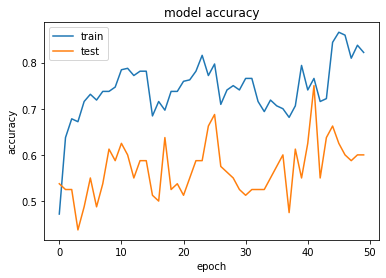

In [ ]:
# summarize history for accuracy
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#PH-CNN
##reference:
###https://github.com/dfioravanti/phylogenetic-cnn
###https://www.tensorflow.org/tutorials/images/cnn

In [ ]:
import os
from tensorflow.keras import datasets, layers, models

##Import coordinate data

In [ ]:
#reshape
!gdown --id '1g-nTEy6WH0JW257ClK8z6R2kdCyzPXz9' --output ordinate.csv
C = pd.read_csv("ordinate.csv")
# Xs = df_final_select.values

Downloading...
From: https://drive.google.com/uc?id=1g-nTEy6WH0JW257ClK8z6R2kdCyzPXz9
To: /content/ordinate.csv
100% 645k/645k [00:00<00:00, 3.94MB/s]


In [ ]:
C = C.drop(shortrun,axis=0)
C.head()

,index,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,Merged
0,SRR3991254,-1.030280,0.069433,0.244558,-0.012325,-0.125265,0.084162,-0.036485,-0.016013,0.002666,0.034913,-0.004449,0.130528,0.065944,-0.013003,0.012479,0.001507,-0.004027,0.088693,0.030586,-0.012455,0.070468,-0.013552,0.053996,0.037850,0.012312,0.001200,0.013277,-0.010320,-0.007080,-0.019159,-0.008311,-0.005322,0.009943,0.002846,0.016234,0.006016,0.021678,-0.013156,0.000354,...,-0.001646,0.011936,0.000483,0.000990,-0.002156,-0.000578,0.001322,-0.002265,-0.000231,-0.001766,0.000023,0.001460,-0.003767,0.000035,0.003584,-0.000085,-0.000498,0.002659,0.000108,-0.001187,7.930000e-05,-0.000152,-0.000037,0.000388,0.000006,0.000028,-1.960000e-07,2.400000e-07,-0.000002,-3.880000e-08,-3.370000e-08,4.820000e-08,-4.700000e-07,-2.190000e-06,2.170000e-07,2.390000e-08,-1.070000e-08,3.510000e-11,1.140000e-10,2634
1,SRR3991066,-1.005713,-0.035924,-0.242050,-0.416232,0.046253,-0.163791,-0.164851,0.133386,0.091378,-0.122375,-0.013333,-0.040536,-0.002351,-0.065758,-0.048241,0.074547,0.012332,0.035942,-0.009469,0.030482,-0.011096,0.018289,-0.017320,-0.037012,-0.023484,0.000715,-0.013735,0.007039,0.027854,0.089398,0.026651,0.025806,0.035810,-0.011375,-0.074843,-0.042492,0.079224,-0.002042,0.003618,...,0.003360,0.001974,0.000898,-0.006607,0.002799,-0.000591,-0.005074,-0.003888,0.000309,0.002102,-0.000020,-0.000575,0.001170,0.000046,-0.002561,0.000069,0.000102,-0.000571,0.000069,-0.000945,-2.960000e-06,0.000021,0.000008,-0.000540,0.000073,0.000003,-1.980000e-08,1.750000e-07,-0.000003,3.680000e-07,4.920000e-08,-8.860000e-09,-4.380000e-08,-2.130000e-07,4.710000e-08,5.760000e-09,-4.060000e-09,2.710000e-11,3.540000e-11,1839
2,SRR3991138,-1.022495,-0.015370,-0.158876,-0.316680,0.169321,-0.043350,-0.091316,0.026494,0.006673,0.015339,0.002486,-0.009025,0.028106,-0.134224,-0.022220,0.117334,0.016242,0.055136,0.042077,-0.130862,-0.147254,0.004714,-0.101034,0.029672,0.101620,-0.010336,-0.036439,-0.002985,-0.017155,-0.044131,0.017068,0.040879,-0.014049,-0.008836,-0.031236,0.048223,-0.012146,-0.008226,-0.000353,...,0.007058,-0.008370,0.003549,-0.001317,-0.002706,-0.001694,-0.006221,0.000907,0.000019,-0.000604,0.000057,0.000194,-0.000720,0.000059,0.000509,-0.000060,0.000337,-0.001769,-0.000067,0.000513,1.360000e-05,0.000028,-0.000013,0.000024,-0.000002,0.000652,6.400000e-08,-1.390000e-07,0.000003,-3.280000e-07,-2.340000e-08,-2.410000e-08,3.230000e-07,1.530000e-06,-1.880000e-07,-2.170000e-08,1.030000e-08,-3.350000e-11,-1.470000e-10,5166
3,SRR3991141,-1.198137,0.056171,0.386348,-0.130579,0.271356,0.193169,0.169649,-0.004176,-0.011641,-0.029952,0.007684,-0.103671,-0.025891,-0.021672,0.022280,0.043790,0.004866,-0.049202,0.011316,-0.003082,-0.010630,-0.005874,-0.028301,0.005662,0.012302,-0.000052,0.024649,-0.002087,0.006156,-0.008315,-0.003773,-0.010680,0.006832,0.000348,-0.008685,-0.022013,0.013507,-0.016410,0.002150,...,0.007010,-0.003486,0.001809,-0.001725,-0.000540,-0.000465,-0.000258,-0.001272,0.000045,0.000482,-0.000017,-0.000640,0.001617,0.000013,-0.002358,0.000051,0.000180,-0.000949,-0.000061,0.000667,-5.190000e-07,0.000012,-0.000006,0.000353,-0.000059,-0.000205,4.670000e-08,-3.140000e-08,-0.000006,8.910000e-07,7.090000e-08,4.840000e-08,-6.410000e-07,-3.110000e-06,4.220000e-07,5.010000e-08,-2.280000e-08,2.000000e-11,4.590000e-10,5558
4,SRR3991276,-1.030864,0.070237,0.251772,-0.015213,-0.114657,0.124548,-0.010685,-0.003018,-0.007834,-0.001328,-0.003265,0.052647,0.038962,-0.064041,0.005910,0.073195,0.009938,-0.040268,0.024305,-0.061981,0.016384,0.018057,0.058869,0.032761,0.029969,-0.001456,-0.026997,-0.034347,-0.003788,-0.018914,-0.003433,0.005958,0.025795,0.002107,0.019063,0.034460,-0.003098,0.001707,-0.000457,...,0.006272,0.003370,-0.001377,0.001833,0.000539,0.001118,0.004925,0.004457,0.00

In [ ]:
not_select=['index', 'Merged']
C_final = C.drop(not_select,axis=1)
C_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 413
Columns: 130 entries, 1 to 130
dtypes: float64(130)
memory usage: 409.4 KB


In [ ]:
C_final.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130
0,-1.030280,0.069433,0.244558,-0.012325,-0.125265,0.084162,-0.036485,-0.016013,0.002666,0.034913,-0.004449,0.130528,0.065944,-0.013003,0.012479,0.001507,-0.004027,0.088693,0.030586,-0.012455,0.070468,-0.013552,0.053996,0.037850,0.012312,0.001200,0.013277,-0.010320,-0.007080,-0.019159,-0.008311,-0.005322,0.009943,0.002846,0.016234,0.006016,0.021678,-0.013156,0.000354,-0.018465,...,-0.000920,-0.001646,0.011936,0.000483,0.000990,-0.002156,-0.000578,0.001322,-0.002265,-0.000231,-0.001766,0.000023,0.001460,-0.003767,0.000035,0.003584,-0.000085,-0.000498,0.002659,0.000108,-0.001187,7.930000e-05,-0.000152,-0.000037,0.000388,0.000006,0.000028,-1.960000e-07,2.400000e-07,-0.000002,-3.880000e-08,-3.370000e-08,4.820000e-08,-4.700000e-07,-2.190000e-06,2.170000e-07,2.390000e-08,-1.070000e-08,3.510000e-11,1.140000e-10
1,-1.005713,-0.035924,-0.242050,-0.416232,0.046253,-0.163791,-0.164851,0.133386,0.091378,-0.122375,-0.013333,-0.040536,-0.002351,-0.065758,-0.048241,0.074547,0.012332,0.035942,-0.009469,0.030482,-0.011096,0.018289,-0.017320,-0.037012,-0.023484,0.000715,-0.013735,0.007039,0.027854,0.089398,0.026651,0.025806,0.035810,-0.011375,-0.074843,-0.042492,0.079224,-0.002042,0.003618,0.014469,...,0.000445,0.003360,0.001974,0.000898,-0.006607,0.002799,-0.000591,-0.005074,-0.003888,0.000309,0.002102,-0.000020,-0.000575,0.001170,0.000046,-0.002561,0.000069,0.000102,-0.000571,0.000069,-0.000945,-2.960000e-06,0.000021,0.000008,-0.000540,0.000073,0.000003,-1.980000e-08,1.750000e-07,-0.000003,3.680000e-07,4.920000e-08,-8.860000e-09,-4.380000e-08,-2.130000e-07,4.710000e-08,5.760000e-09,-4.060000e-09,2.710000e-11,3.540000e-11
2,-1.022495,-0.015370,-0.158876,-0.316680,0.169321,-0.043350,-0.091316,0.026494,0.006673,0.015339,0.002486,-0.009025,0.028106,-0.134224,-0.022220,0.117334,0.016242,0.055136,0.042077,-0.130862,-0.147254,0.004714,-0.101034,0.029672,0.101620,-0.010336,-0.036439,-0.002985,-0.017155,-0.044131,0.017068,0.040879,-0.014049,-0.008836,-0.031236,0.048223,-0.012146,-0.008226,-0.000353,-0.017857,...,-0.002041,0.007058,-0.008370,0.003549,-0.001317,-0.002706,-0.001694,-0.006221,0.000907,0.000019,-0.000604,0.000057,0.000194,-0.000720,0.000059,0.000509,-0.000060,0.000337,-0.001769,-0.000067,0.000513,1.360000e-05,0.000028,-0.000013,0.000024,-0.000002,0.000652,6.400000e-08,-1.390000e-07,0.000003,-3.280000e-07,-2.340000e-08,-2.410000e-08,3.230000e-07,1.530000e-06,-1.880000e-07,-2.170000e-08,1.030000e-08,-3.350000e-11,-1.470000e-10
3,-1.198137,0.056171,0.386348,-0.130579,0.271356,0.193169,0.169649,-0.004176,-0.011641,-0.029952,0.007684,-0.103671,-0.025891,-0.021672,0.022280,0.043790,0.004866,-0.049202,0.011316,-0.003082,-0.010630,-0.005874,-0.028301,0.005662,0.012302,-0.000052,0.024649,-0.002087,0.006156,-0.008315,-0.003773,-0.010680,0.006832,0.000348,-0.008685,-0.022013,0.013507,-0.016410,0.002150,0.008708,...,-0.000691,0.007010,-0.003486,0.001809,-0.001725,-0.000540,-0.000465,-0.000258,-0.001272,0.000045,0.000482,-0.000017,-0.000640,0.001617,0.000013,-0.002358,0.000051,0.000180,-0.000949,-0.000061,0.000667,-5.190000e-07,0.000012,-0.000006,0.000353,-0.000059,-0.000205,4.670000e-08,-3.140000e-08,-0.000006,8.910000e-07,7.090000e-08,4.840000e-08,-6.410000e-07,-3.110000e-06,4.220000e-07,5.010000e-08,-2.280000e-08,2.000000e-11,4.590000e-10
4,-1.030864,0.070237,0.251772,-0.015213,-0.114657,0.124548,-0.010685,-0.003018,-0.007834,-0.001328,-0.003265,0.052647,0.038962,-0.064041,0.005910,0.073195,0.009938,-0.040268,0.024305,-0.061981,0.016384,0.018057,0.058869,0.032761,0.029969,-0.001456,-0.026997,-0.034347,-0.003788,-0.018914,-0.003433,0.005958,0.025795,0.002107,0.019063,0.034460,-0.003098,0.001707,-0.000457,-0.021793,...,-0.000625,0.006272,0.003370,-0.001377,0.001833,0.000539,0.001118,0.00492

In [ ]:
X_final = pd.concat([df_final_select, C_final], axis=1)
X_final.shape

(400, 837)

In [ ]:
target_var = 'Cancer'
features = list(X_final.columns)
# 目標變量的類別
Class = train[target_var].unique()
# 目標變量的類別字典
Class_dict = dict(zip(Class, range(len(Class))))
# 增加一列target, 將目標變量進行編碼
train['target'] = train[target_var].apply(lambda x: Class_dict[x])
# 對目標變量進行0-1編碼(One-hot Encoding)
lb = LabelBinarizer()
lb.fit(list(Class_dict.values()))
transformed_labels = lb.transform(train['target'])
label2 = np.zeros((400,1))

for i in range(len(transformed_labels)):
  if transformed_labels[i][0] == 0:
    label2[i][0] = np.int(1)
  elif transformed_labels[i][0] == 1:
    label2[i][0] = np.int(0)

transformed_labels = np.concatenate((transformed_labels, label2),axis=1)

y_bin_labels = []  # 對多分類進行0-1編碼的變量
for i in range(transformed_labels.shape[1]):
    y_bin_labels.append( 'y' + str(i))
    train['y' + str(i)] = transformed_labels[:, i]
# 將數據集分為訓練集和測試集
train_x, test_x, train_y, test_y = train_test_split(X_final[features], train[y_bin_labels], train_size=0.8, test_size=0.2, random_state=0)

In [ ]:
train_x = train_x.values.reshape(320, 3, 3, 93)
train_x = train_x.reshape(320, 3, 3, 93)
test_x = test_x.values.reshape(80, 3, 3, 93)
test_x = test_x.reshape(80, 3, 3, 93)

## Model(Same as paper)

In [ ]:
model = K.models.Sequential()
model.add(K.layers.Conv2D(93, (1, 1), activation='relu', input_shape=train_x.shape[1:]))
model.add(K.layers.Conv2D(50, (1, 1), activation='relu', input_shape=train_x.shape[1:]))
model.add(K.layers.MaxPooling2D((2, 2)))
model.add(K.layers.Flatten())
model.add(K.layers.Dense(64, activation= 'relu'))
model.add(K.layers.Dropout(0.25))
model.add(K.layers.Dense(2,activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 3, 3, 93)          8742      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 3, 50)          4700      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 1, 50)          0         
_________________________________________________________________
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 64)                3264      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 2)                

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
# opt = K.optimizers.Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy',
        metrics=['accuracy'])

h2 = model.fit(train_x, train_y, epochs=50, batch_size=4,
      validation_data=(test_x, test_y))

Epoch 1/50
80/80 [==============================] - 29s 5ms/step - loss: 0.6924 - accuracy: 0.5375 - val_loss: 0.6955 - val_accuracy: 0.4500
Epoch 2/50
80/80 [==============================] - 0s 4ms/step - loss: 0.6878 - accuracy: 0.5625 - val_loss: 0.6985 - val_accuracy: 0.4625
Epoch 3/50
80/80 [==============================] - 0s 4ms/step - loss: 0.6853 - accuracy: 0.5875 - val_loss: 0.6999 - val_accuracy: 0.4625
Epoch 4/50
80/80 [==============================] - 0s 3ms/step - loss: 0.6804 - accuracy: 0.5938 - val_loss: 0.7025 - val_accuracy: 0.4750
Epoch 5/50
80/80 [==============================] - 0s 3ms/step - loss: 0.6750 - accuracy: 0.5844 - val_loss: 0.7040 - val_accuracy: 0.4500
Epoch 6/50
80/80 [==============================] - 0s 4ms/step - loss: 0.6734 - accuracy: 0.5906 - val_loss: 0.7146 - val_accuracy: 0.4750
Epoch 7/50
80/80 [==============================] - 0s 4ms/step - loss: 0.6665 - accuracy: 0.6094 - val_loss: 0.7194 - val_accuracy: 0.4875
Epoch 8/50
80/80 [=

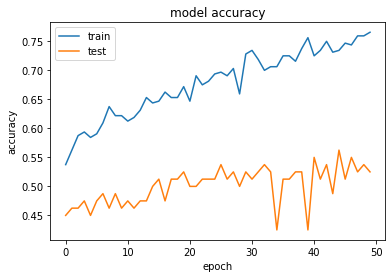

In [ ]:
# summarize history for accuracy
plt.plot(h2.history['accuracy'])
plt.plot(h2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##Model 2
Activation = relu  
No Dropout

In [ ]:
model = K.models.Sequential()
model.add(K.layers.Conv2D(93, (3, 3), activation='relu', input_shape=train_x.shape[1:]))
# model.add(K.layers.Conv2D(50, (1, 1), activation='relu', input_shape=train_x.shape[1:]))
# model.add(K.layers.MaxPooling2D((2, 2)))
model.add(K.layers.Flatten())
model.add(K.layers.Dense(32, activation= 'relu'))
model.add(K.layers.Dropout(0.15))
model.add(K.layers.Dense(2,activation='relu'))

In [ ]:
model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 1, 1, 93)          77934     
_________________________________________________________________
flatten_20 (Flatten)         (None, 93)                0         
_________________________________________________________________
dense_66 (Dense)             (None, 32)                3008      
_________________________________________________________________
dropout_20 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_67 (Dense)             (None, 2)                 66        
Total params: 81,008
Trainable params: 81,008
Non-trainable params: 0
_________________________________________________________________


In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0003, decay=1e-3)
model.compile(optimizer=opt, loss='categorical_crossentropy',
        metrics=['accuracy'])

h2 = model.fit(train_x, train_y, epochs=50, batch_size=4,
      validation_data=(test_x, test_y))

Epoch 1/50
80/80 [==============================] - 1s 4ms/step - loss: 1.7432 - accuracy: 0.4469 - val_loss: 0.7639 - val_accuracy: 0.4250
Epoch 2/50
80/80 [==============================] - 0s 3ms/step - loss: 0.8003 - accuracy: 0.5312 - val_loss: 0.7429 - val_accuracy: 0.4750
Epoch 3/50
80/80 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.5594 - val_loss: 0.7125 - val_accuracy: 0.5500
Epoch 4/50
80/80 [==============================] - 0s 3ms/step - loss: 0.6277 - accuracy: 0.6344 - val_loss: 0.6961 - val_accuracy: 0.5875
Epoch 5/50
80/80 [==============================] - 0s 3ms/step - loss: 0.6150 - accuracy: 0.6687 - val_loss: 0.6783 - val_accuracy: 0.6000
Epoch 6/50
80/80 [==============================] - 0s 3ms/step - loss: 0.6244 - accuracy: 0.6375 - val_loss: 0.6712 - val_accuracy: 0.6000
Epoch 7/50
80/80 [==============================] - 0s 3ms/step - loss: 0.6627 - accuracy: 0.7188 - val_loss: 0.6538 - val_accuracy: 0.5875
Epoch 8/50
80/80 [==

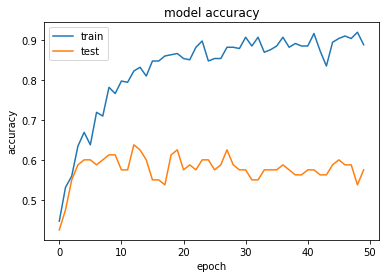

In [ ]:
# summarize history for accuracy
plt.plot(h2.history['accuracy'])
plt.plot(h2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()